In [1]:
import os
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yaml
from loguru import logger
from tqdm import tqdm
import natsort
import glob
import cv2
from PIL import Image
from data.dataset import Sentinel2TCIDataset, Sentinel2Dataset
from data.loader import define_loaders
from model_zoo.models import define_model
from training.metrics import MultiSpectralMetrics, avg_metric_bands
from utils.torch import count_parameters, load_model_weights, seed_everything
from utils.utils import load_config
from utils.wandb_logger import WandbLogger
from training.losses import WeightedMSELoss

/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prepare_paths(path_dir):


    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output


def prepare_data(config):
    base_dir = config['DATASET']['base_dir']
    version = config['DATASET']['version']
    resize = config['TRAINING']['resize']


    TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/train/"
    VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/val/"
    TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"

    df_train_input, df_train_output =  prepare_paths(TRAIN_DIR)
    df_val_input, df_val_output =  prepare_paths(VAL_DIR)
    df_test_input, df_test_output =  prepare_paths(TEST_DIR)

    logger.info(f"Number of training samples: {len(df_train_input)}")
    logger.info(f"Number of validation samples: {len(df_val_input)}")
    logger.info(f"Number of test samples: {len(df_test_input)}")

    train_dataset = Sentinel2Dataset(df_x=df_train_input, df_y=df_train_output, train=True, augmentation=False, img_size=resize)
    val_dataset = Sentinel2Dataset(df_x=df_val_input, df_y=df_val_output, train=True, augmentation=False, img_size=resize)
    test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)



    train_loader, val_loader = define_loaders(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        train=True,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    test_loader = define_loaders(
        train_dataset=test_dataset,
        val_dataset=None,
        train=False,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    return train_loader, val_loader, test_loader


In [3]:
config = load_config(config_path="cfg/config.yaml")
version = "V3"
resize = 1024
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_input, df_output = prepare_paths(TEST_DIR)

In [4]:
def normalize(data_array):
    """
    Normalize the data array to the range [0, 1].
    """
    normalized_data = []
    valid_masks= []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        result = band_data.copy().astype(np.float32)
        result[valid_mask] = result[valid_mask] / 10000
        result[valid_mask] = np.clip(result[valid_mask], 0, 1)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks)

def read_images(product_paths):
    """
    Read and stack a list of grayscale image files into a multi-band image.

    Parameters
    ----------
    product_paths : list of str
        List of file paths to the images to read.

    Returns
    -------
    images : ndarray
        A 3D NumPy array of shape (H, W, C), where each image is treated as one band (C channels).
    """

    images = []
    for path in product_paths:
        data = Image.open(path)
        data = np.array(data)
        images.append(data)
    # H x W x C
    images = np.dstack(images)
    return images

In [22]:
random_index = np.random.choice(df_input.index)
random_row = df_input.loc[random_index]

x_paths = natsort.natsorted(glob.glob(os.path.join(df_input["path"][random_index], "*.png")))
y_paths = natsort.natsorted(glob.glob(os.path.join(df_output["path"][random_index], "*.png")))

x_data = read_images(x_paths)
x_data, x_mask = normalize(x_data)
y_data = read_images(y_paths)
y_data = read_images(y_paths)
y_data, y_mask = normalize(y_data)

In [23]:
x_data.shape

(1830, 1830, 3)

In [ ]:
from data.transform import get_transforms
import albumentations as A


def get_transforms(train=True, augmentation=True, aug_prob=0.7):
    """
    Get transforms with separate pipelines for inputs and targets.

    Args:
        train (bool): Whether in training mode
        augmentation (bool): Whether augmentation is allowed
        aug_prob (float): Probability of applying any augmentation

    Returns:
        Albumentations transforms with separate handling for inputs and targets
    """
    if train and augmentation:
        # Geometric transformations (applied to both input and target)
        geometric_transforms = [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Transpose(p=0.5)
        ]
        # Quality degradation transforms (applied only to input)
        quality_transforms = [
            A.GaussNoise(var_limit=(5.0, 10.0), p=0.5),
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),

            A.RandomBrightnessContrast(p=0.5)
        ]

        # Combine everything with proper probabilities
        return A.Compose([
            # First apply geometric transformations to both input and target
            A.OneOf([
                A.Compose(geometric_transforms, p=1.0),
                A.Compose([], p=1.0)  # No geometric augmentation option
            ], p=aug_prob),

            # Then apply quality transforms to just the input image
            A.OneOf([
                A.Compose(quality_transforms, p=1.0),
                A.Compose([], p=1.0)  # No quality augmentation option
            ], p=aug_prob)
        ], additional_targets={'mask': 'mask'})
    else:
        # No transformations for val/test
        return A.Compose([], additional_targets={'mask': 'mask'})


transform = get_transforms(train=True, augmentation=True, aug_prob=0.5)

In [155]:
transformed = transform(image=x_data, mask=y_data)
x_data_aug = transformed["image"]
y_data_aug = transformed["mask"]

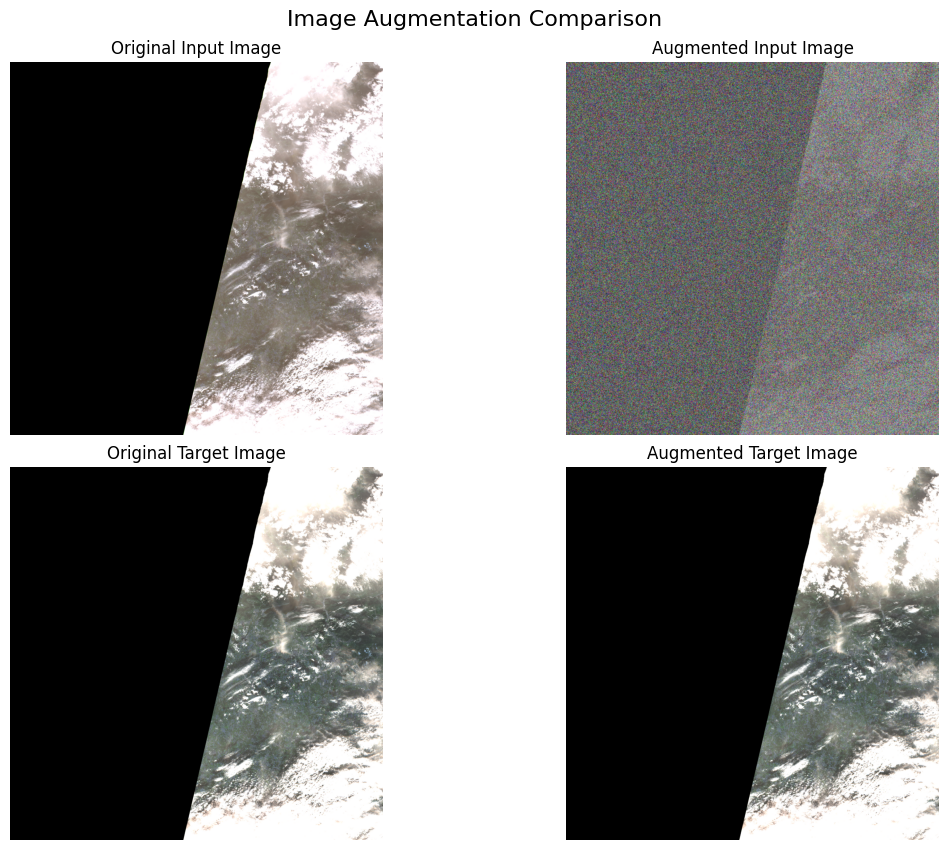

In [157]:
import matplotlib.pyplot as plt

# Apply the transformations
transformed = transform(image=x_data, mask=y_data)
x_data_aug = transformed["image"]
y_data_aug = transformed["mask"]

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Image Augmentation Comparison", fontsize=16)

# Plot original input
axes[0, 0].imshow(x_data)
axes[0, 0].set_title("Original Input Image")
axes[0, 0].axis('off')

# Plot augmented input
axes[0, 1].imshow(x_data_aug)
axes[0, 1].set_title("Augmented Input Image")
axes[0, 1].axis('off')

# Plot original target
axes[1, 0].imshow(y_data)
axes[1, 0].set_title("Original Target Image")
axes[1, 0].axis('off')

# Plot augmented target
axes[1, 1].imshow(y_data_aug)
axes[1, 1].set_title("Augmented Target Image")
axes[1, 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the note
plt.show()

In [158]:
y_data_aug.std()

0.3881825

In [159]:
y_data.std()

0.3881825

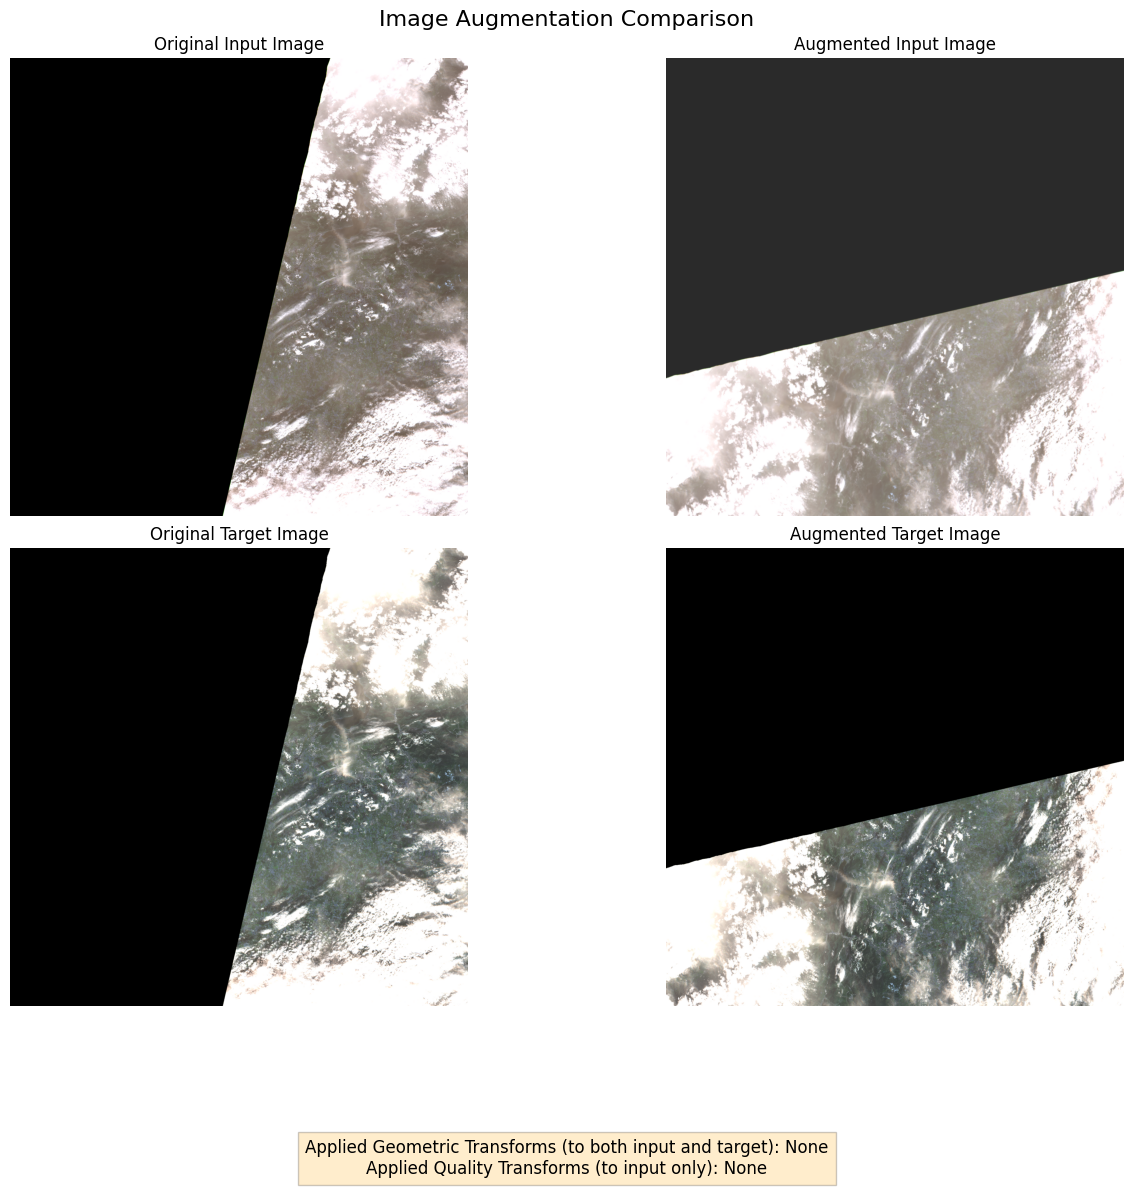

{'geometric': [], 'quality': []}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

import albumentations as A

def get_transforms(train=True, augmentation=True, aug_prob=0.7, verbose=False):
    """
    Get transforms with separate pipelines for inputs and targets.
    - Geometric transformations applied to both input and mask
    - Quality/degradation transformations applied only to input (not to mask)

    Returns applied transforms when verbose=True.
    """
    applied_transforms = {'geometric': [], 'quality': []}

    class TransformLogger:
        def __init__(self, transform_type):
            self.transform_type = transform_type

        def __call__(self, *args, **kwargs):
            # Get the transform name from the first arg (the object instance)
            transform_name = args[0].__class__.__name__ if args else "Unknown"
            applied_transforms[self.transform_type].append(transform_name)
            return True  # Continue with the transform

    if train and augmentation:
        # Define transforms pipeline
        transforms_list = [
            # Geometric transformations - will be applied to both input and mask
            A.HorizontalFlip(p=0.5 * aug_prob),
            A.VerticalFlip(p=0.5 * aug_prob),
            A.RandomRotate90(p=0.5 * aug_prob),
            A.Transpose(p=0.5 * aug_prob),

            # Quality degradation transforms - will ONLY be applied to the input image
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.5 * aug_prob),
            A.GaussianBlur(blur_limit=(3, 5), p=0.5 * aug_prob),
            A.ColorJitter(brightness=0.2, contrast=0.2, p=0.5 * aug_prob),
            A.RandomBrightnessContrast(p=0.5 * aug_prob)
        ]

        # Add callbacks to log transforms if verbose
        if verbose:
            for t in transforms_list[:4]:  # First 4 are geometric
                t.p_callback = TransformLogger('geometric')
            for t in transforms_list[4:]:  # Remaining are quality
                t.p_callback = TransformLogger('quality')

        # In albumentations, by default, transforms only apply to 'image'
        # We need to explicitly set which transforms should also apply to 'mask'
        return A.Compose(
            transforms_list,
            additional_targets={'mask': 'mask'}  # This makes 'mask' treated as a mask
        ), applied_transforms
    else:
        # No transformations for val/test
        return A.Compose([], additional_targets={'mask': 'mask'}), applied_transforms



def show_transformations(x_data, y_data, transform, verbose=True):
    """
    Visualize the original and transformed images with information about applied transforms.
    """
    if verbose:
        transform_fn, applied_transforms = get_transforms(train=True, augmentation=True, aug_prob=0.5, verbose=True)
    else:
        transform_fn = transform
        applied_transforms = {'geometric': [], 'quality': []}

    # Apply the transformations
    transformed = transform_fn(image=x_data, mask=y_data)
    x_data_aug = transformed["image"]
    y_data_aug = transformed["mask"]

    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle("Image Augmentation Comparison", fontsize=16)

    # Plot original input
    axes[0, 0].imshow(x_data)
    axes[0, 0].set_title("Original Input Image")
    axes[0, 0].axis('off')

    # Plot augmented input
    axes[0, 1].imshow(x_data_aug)
    axes[0, 1].set_title("Augmented Input Image")
    axes[0, 1].axis('off')

    # Plot original target
    axes[1, 0].imshow(y_data)
    axes[1, 0].set_title("Original Target Image")
    axes[1, 0].axis('off')

    # Plot augmented target
    axes[1, 1].imshow(y_data_aug)
    axes[1, 1].set_title("Augmented Target Image")
    axes[1, 1].axis('off')

    # Add a note about the applied transformations if verbose
    if verbose:
        geometric_list = ", ".join(applied_transforms['geometric']) if applied_transforms['geometric'] else "None"
        quality_list = ", ".join(applied_transforms['quality']) if applied_transforms['quality'] else "None"

        transform_text = (
            f"Applied Geometric Transforms (to both input and target): {geometric_list}\n"
            f"Applied Quality Transforms (to input only): {quality_list}"
        )
    else:
        transform_text = (
            "Geometric transformations applied to both input and target.\n"
            "Quality/noise transformations applied only to input image."
        )

    plt.figtext(0.5, 0.01, transform_text, ha="center", fontsize=12,
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the note
    plt.show()

    return applied_transforms

# Usage
transform = get_transforms(train=True, augmentation=True, aug_prob=0.5)[0]  # Just get the transform function
show_transformations(x_data, y_data, transform, verbose=True)


In [126]:
transform

Compose([
  OneOf([
    Compose([
      HorizontalFlip(always_apply=False, p=0.5),
      VerticalFlip(always_apply=False, p=0.5),
      RandomRotate90(always_apply=False, p=0.5),
      Transpose(always_apply=False, p=0.5),
    ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'mask': 'image'}, is_check_shapes=True),
    Compose([
    ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'mask': 'image'}, is_check_shapes=True),
  ], p=0.5),
  OneOf([
    Compose([
      GaussNoise(always_apply=False, p=0.5, var_limit=(5.0, 20.0), per_channel=True, mean=0.0),
      GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5), sigma_limit=(0, 0)),
      ColorJitter(always_apply=False, p=0.5, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=(0.8, 1.0), hue=(-0.5, 0.5)),
      RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
    ], p=1.0, bbox_params=None, keypoint_pa